In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np


In [2]:

def generate_mackey_glass(beta=0.2, gamma=0.1, n=10, tau=25, x0=1.5, dt=1, length=2000):

    x = np.zeros(length)
    x[0] = x0

    delay = int(tau / dt)
    for t in range(1, length):
        delayed_idx = t - delay if t >= delay else None
        delayed_x = x[delayed_idx] if delayed_idx is not None else 0
        x[t] = x[t - 1] + dt * (
            beta * delayed_x / (1 + delayed_x**n) - gamma * x[t - 1]
        )
    return x

def generate_data(x, start_idx=301, end_idx=1500, train_ratio=0.7, val_ratio=0.15, noise_std_factor=0.0):
    """
    Generate training, validation, and testing datasets for Mackey-Glass time series.
    """
    t = np.arange(start_idx, end_idx + 1)
    inputs = np.array([x[t - 20], x[t - 15], x[t - 10], x[t - 5], x[t]]).T
    outputs = x[t + 5]

    total_points = inputs.shape[0]
    train_end = int(total_points * train_ratio)
    val_end = train_end + int(total_points * val_ratio)

    # Split data into train, val, and test sets
    train_inputs = inputs[:train_end]
    train_outputs = outputs[:train_end]

    val_inputs = inputs[train_end:val_end]
    val_outputs = outputs[train_end:val_end]

    test_inputs = inputs[val_end:]
    test_outputs = outputs[val_end:]

    # Add Gaussian noise to training data (if enabled ofc))
    if noise_std_factor > 0:
        noise_std = noise_std_factor * np.std(train_outputs)  # Scale noise std by data std
        train_outputs += np.random.normal(0, noise_std, size=train_outputs.shape)

    return (train_inputs, train_outputs), (val_inputs, val_outputs), (test_inputs, test_outputs)

x = generate_mackey_glass()

train, val, test = generate_data(x)


In [3]:

# Define MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers):
        super(MLP, self).__init__()
        layers = []
        in_features = input_size
        for hidden_units in hidden_layers:
            layers.append(nn.Linear(in_features, hidden_units))
            layers.append(nn.ReLU())
            in_features = hidden_units
        layers.append(nn.Linear(in_features, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

def train_and_evaluate(train, val, test, layer_configurations, early_stopping = True, weight_decay = 0.0):
    train_inputs = torch.tensor(train[0], dtype=torch.float32)
    train_outputs = torch.tensor(train[1], dtype=torch.float32).view(-1, 1)
    val_inputs = torch.tensor(val[0], dtype=torch.float32)
    val_outputs = torch.tensor(val[1], dtype=torch.float32).view(-1, 1)
    test_inputs = torch.tensor(test[0], dtype=torch.float32)
    test_outputs = torch.tensor(test[1], dtype=torch.float32).view(-1, 1)

    best_config = None
    worst_config = None
    best_val_error = float('inf')
    worst_val_error = float('-inf')

    val_errors = []
    test_errors = []

    # Grid search
    for config in layer_configurations:
        nh1, nh2 = config
        model = MLP(input_size=train_inputs.shape[1], hidden_layers=[nh1, nh2])
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay) 

        best_val_loss = float('inf')
        patience = 10
        trigger_times = 0

        for epoch in range(1000):
            model.train()
            optimizer.zero_grad()
            outputs = model(train_inputs)
            loss = criterion(outputs, train_outputs)
            loss.backward()
            optimizer.step()
            model.eval()
            
            with torch.no_grad():
                val_outputs_pred = model(val_inputs)
                val_loss = criterion(val_outputs_pred, val_outputs)
                
            if early_stopping:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    trigger_times = 0
                else:
                    trigger_times += 1

                if trigger_times >= patience:
                    print(trigger_times, epoch)
                    break

        val_error = best_val_loss.item()
        val_errors.append((config, val_error))

        # Evaluate model on test
        with torch.no_grad():
            test_outputs_pred = model(test_inputs)
            test_error = mean_squared_error(test_outputs.numpy(), test_outputs_pred.numpy())
            test_errors.append((config, test_error))

        # Update best and worst configs
        if val_error < best_val_error:
            best_val_error = val_error
            best_config = config
        if val_error > worst_val_error:
            worst_val_error = val_error
            worst_config = config

    print(f"Best configuration: {best_config} with validation error: {best_val_error}")
    print(f"Worst configuration: {worst_config} with validation error: {worst_val_error}")

    # Plot validation and test errors for each config
    
    configs, val_errs = zip(*val_errors)
    _, test_errs = zip(*test_errors)
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(configs)), val_errs, marker='o', label='Validation Error')
    plt.plot(range(len(configs)), test_errs, marker='x', label='Test Error')
    plt.xticks(range(len(configs)), configs, rotation=45)
    plt.xlabel('Layer Configurations (nh1, nh2)')
    plt.ylabel('Error')
    plt.title('Validation and Test Errors for Different Layer Configurations')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluate best and worst models on the test set
    best_model = MLP(input_size=train_inputs.shape[1], hidden_layers=best_config)
    best_model.eval()
    with torch.no_grad():
        test_outputs_pred = best_model(test_inputs)
        test_error = mean_squared_error(test_outputs.numpy(), test_outputs_pred.numpy())
    print(f"Test error for the best configuration: {test_error}")
    
    worst_model = MLP(input_size=train_inputs.shape[1], hidden_layers=worst_config)
    worst_model.eval()
    with torch.no_grad():
        test_outputs_pred = worst_model(test_inputs)
        test_error = mean_squared_error(test_outputs.numpy(), test_outputs_pred.numpy())
    print(f"Test error for the worst configuration: {test_error}")
    
    return best_config, worst_config, best_model, worst_model



10 551
Best configuration: (4, 4) with validation error: 0.01046560425311327
Worst configuration: (5, 2) with validation error: 0.5851102471351624


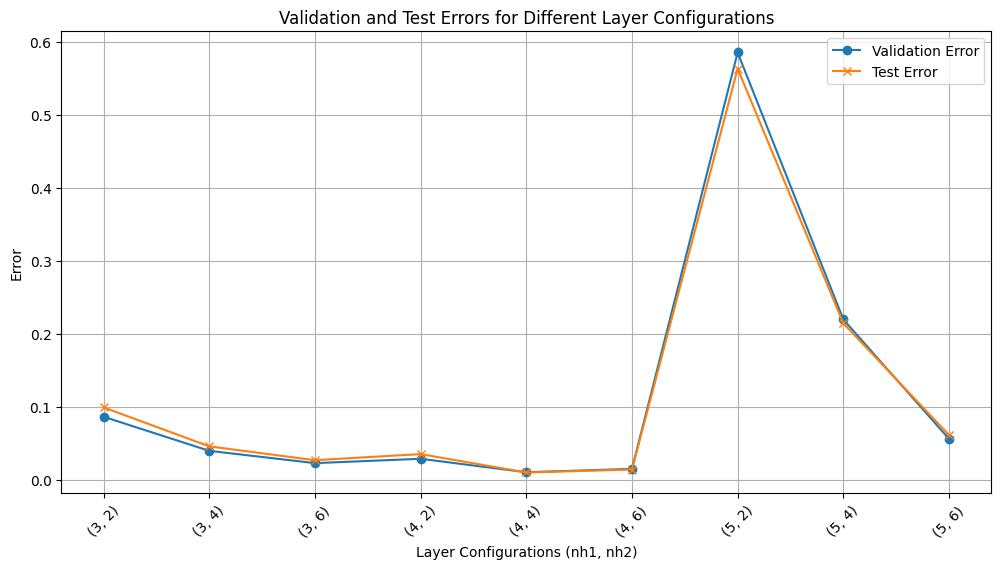

Test error for the best configuration: 0.6492775082588196
Test error for the worst configuration: 0.7375504374504089


In [4]:
layer_configurations = [(i, y) for i in [3, 4, 5] for y in [2, 4, 6]]

best_config, worst_config, best_model, worst_model = train_and_evaluate(train, val, test, layer_configurations)


### Evaluating with Gaussian noise (σ = 0.05) and weight decay (λ = 0.0) ###
Best configuration: (4, 9) with validation error: 0.01160428300499916
Worst configuration: (4, 3) with validation error: 0.41786083579063416


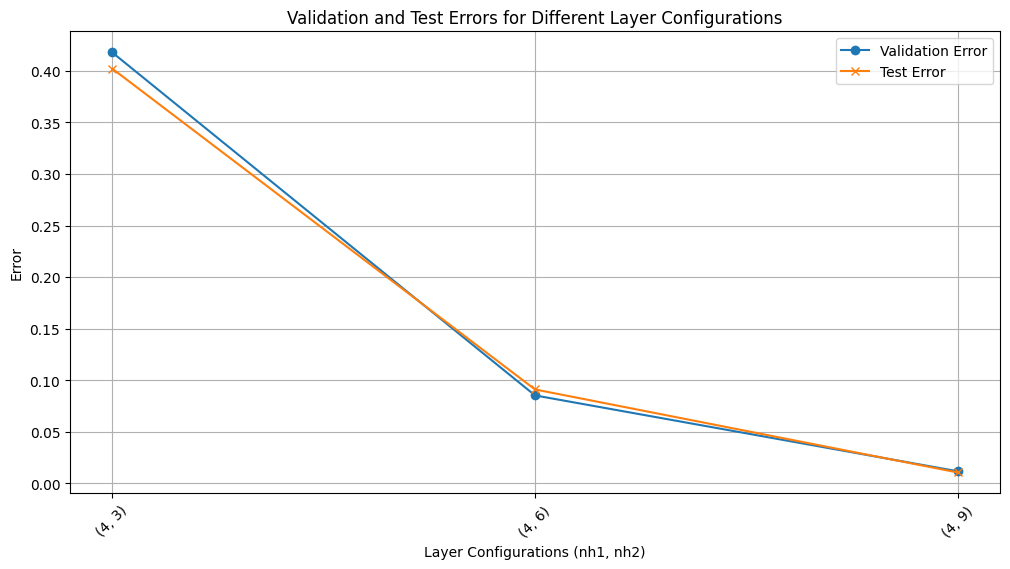

Test error for the best configuration: 0.9135643839836121
Test error for the worst configuration: 2.6741671562194824

### Evaluating with Gaussian noise (σ = 0.05) and weight decay (λ = 0.01) ###
Best configuration: (4, 9) with validation error: 0.017709899693727493
Worst configuration: (4, 6) with validation error: 0.05854421854019165


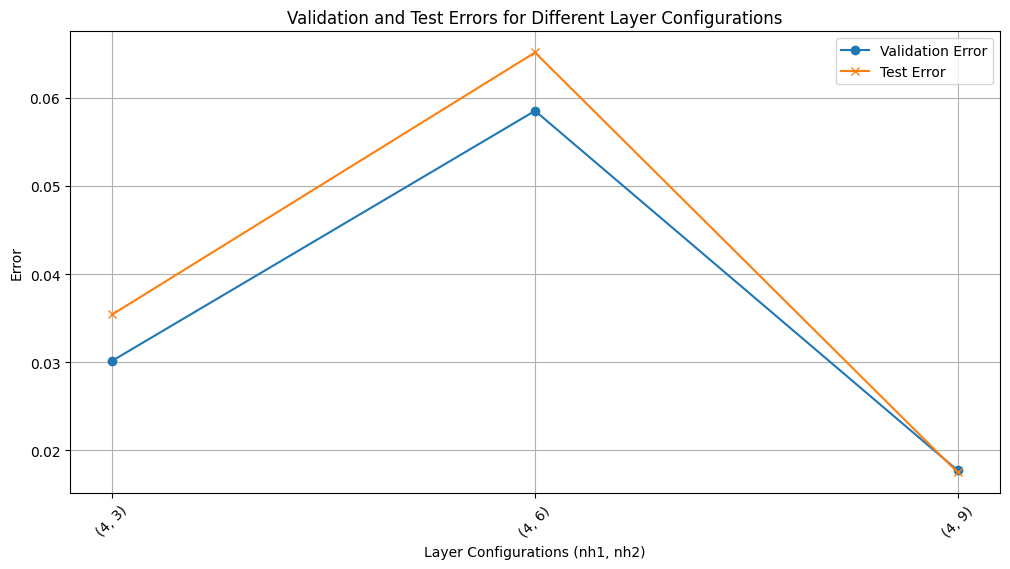

Test error for the best configuration: 0.6242923140525818
Test error for the worst configuration: 0.272360622882843

### Evaluating with Gaussian noise (σ = 0.05) and weight decay (λ = 0.1) ###
Best configuration: (4, 9) with validation error: 0.06513407081365585
Worst configuration: (4, 3) with validation error: 0.092525415122509


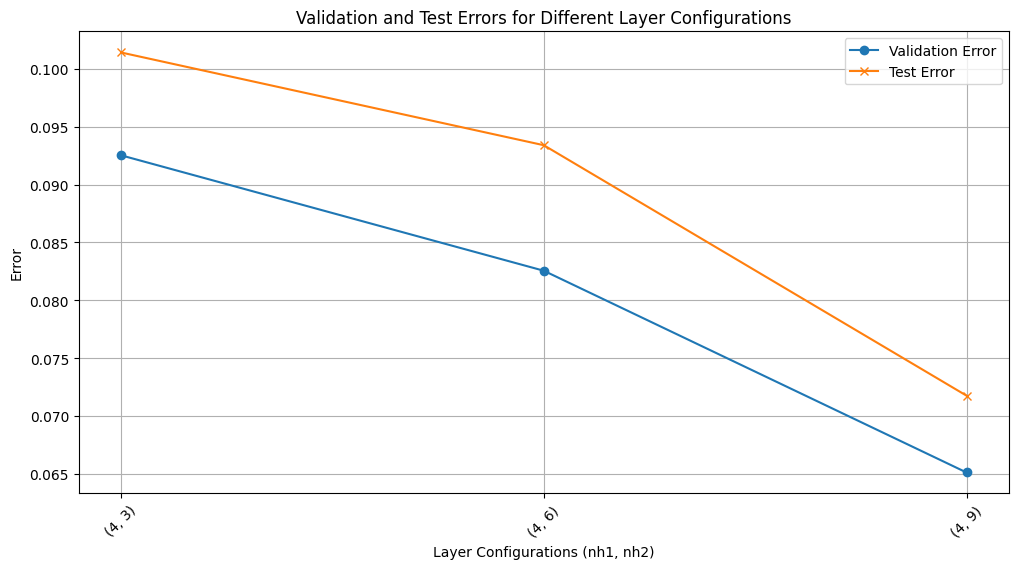

Test error for the best configuration: 0.6932097673416138
Test error for the worst configuration: 1.1569323539733887

### Evaluating with Gaussian noise (σ = 0.09) and weight decay (λ = 0.0) ###
10 596
Best configuration: (4, 6) with validation error: 0.03854120522737503
Worst configuration: (4, 9) with validation error: 0.08629228919744492


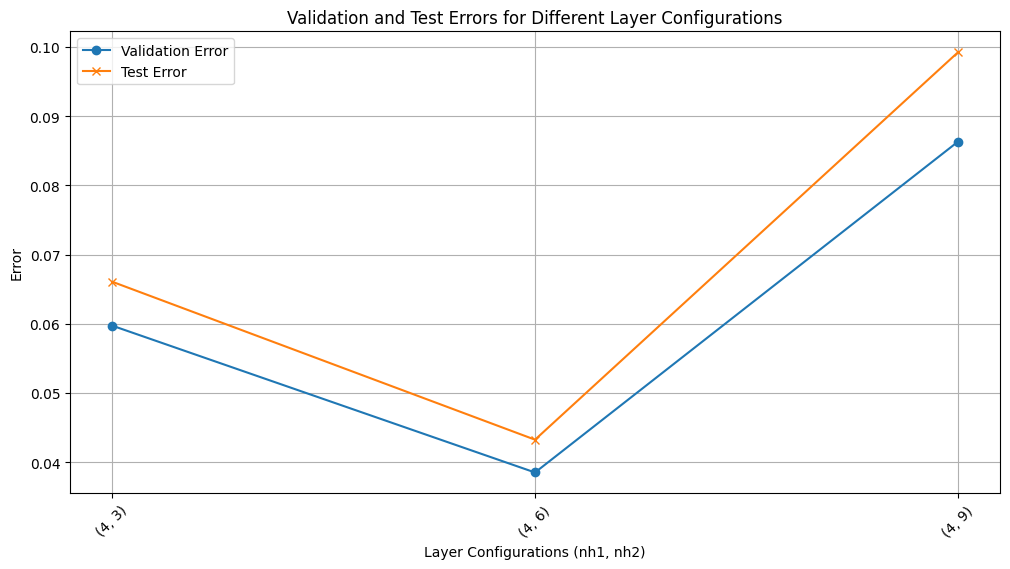

Test error for the best configuration: 0.944596529006958
Test error for the worst configuration: 1.6630550622940063

### Evaluating with Gaussian noise (σ = 0.09) and weight decay (λ = 0.01) ###
10 937
Best configuration: (4, 9) with validation error: 0.03539426624774933
Worst configuration: (4, 3) with validation error: 0.08629978448152542


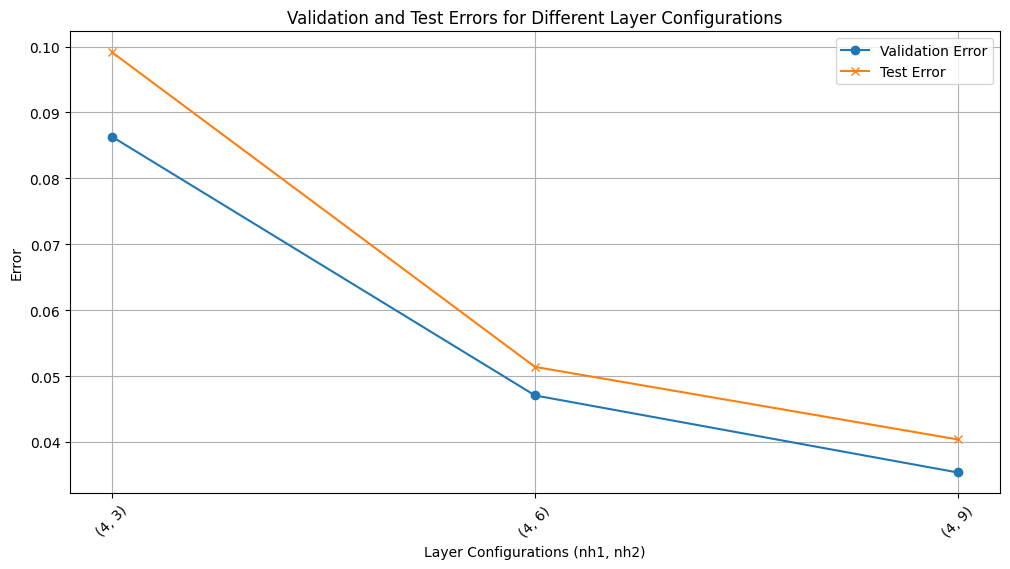

Test error for the best configuration: 0.3205050230026245
Test error for the worst configuration: 1.3572869300842285

### Evaluating with Gaussian noise (σ = 0.09) and weight decay (λ = 0.1) ###
10 486
10 165
Best configuration: (4, 9) with validation error: 0.06480710208415985
Worst configuration: (4, 6) with validation error: 0.08442256599664688


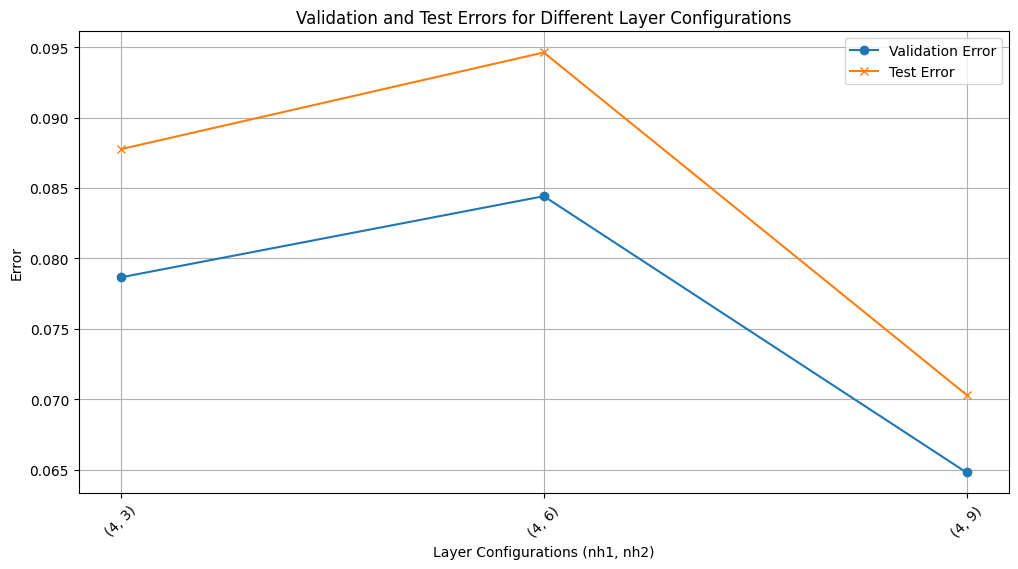

Test error for the best configuration: 0.953472375869751
Test error for the worst configuration: 1.0868719816207886

### Evaluating with Gaussian noise (σ = 0.15) and weight decay (λ = 0.0) ###
Best configuration: (4, 9) with validation error: 0.014304985292255878
Worst configuration: (4, 3) with validation error: 0.11123824864625931


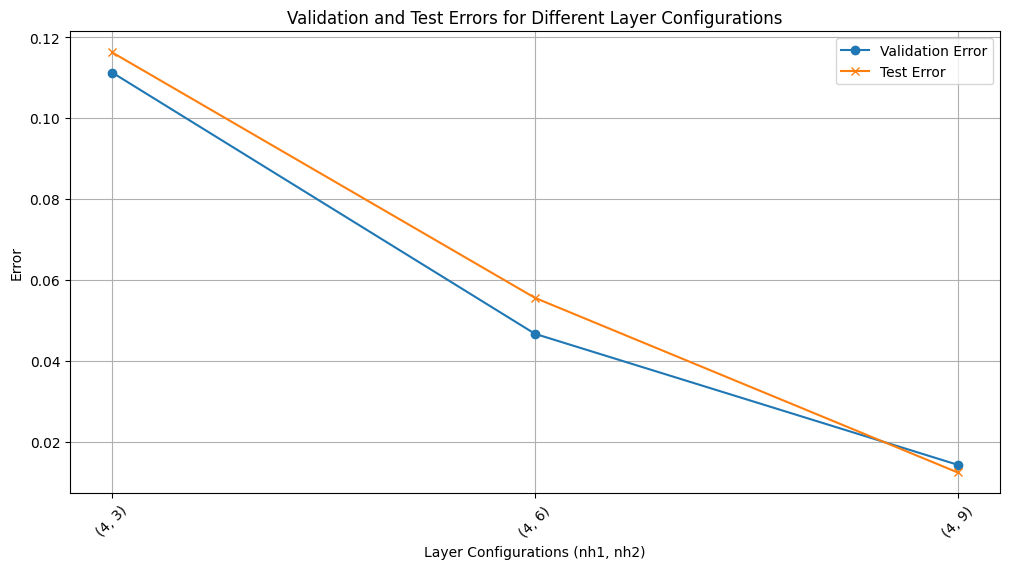

Test error for the best configuration: 0.580459475517273
Test error for the worst configuration: 0.4750254452228546

### Evaluating with Gaussian noise (σ = 0.15) and weight decay (λ = 0.01) ###
10 932
Best configuration: (4, 9) with validation error: 0.022285161539912224
Worst configuration: (4, 3) with validation error: 0.08629424124956131


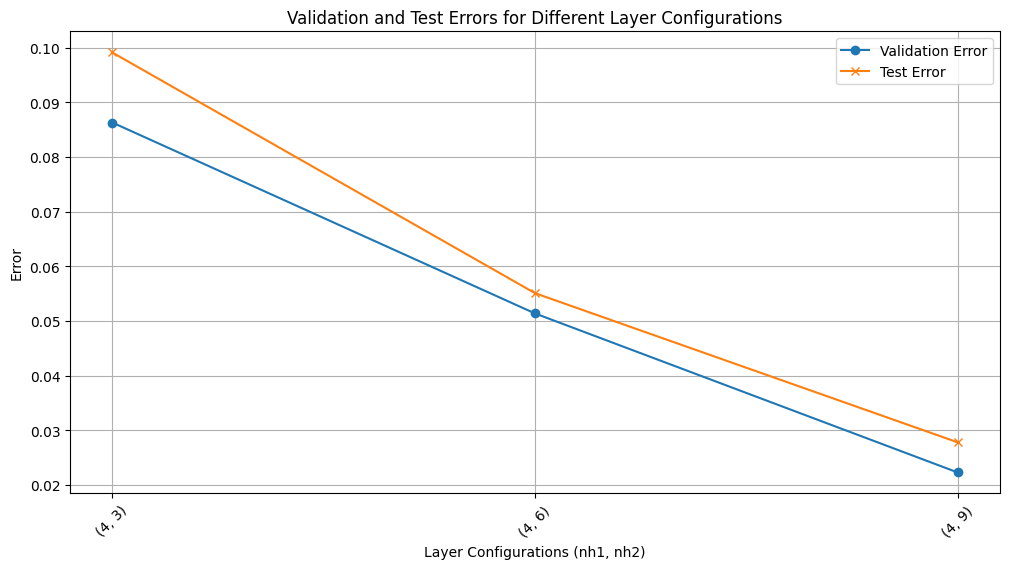

Test error for the best configuration: 0.32568854093551636
Test error for the worst configuration: 2.2093074321746826

### Evaluating with Gaussian noise (σ = 0.15) and weight decay (λ = 0.1) ###
Best configuration: (4, 9) with validation error: 0.06493690609931946
Worst configuration: (4, 3) with validation error: 0.0901520624756813


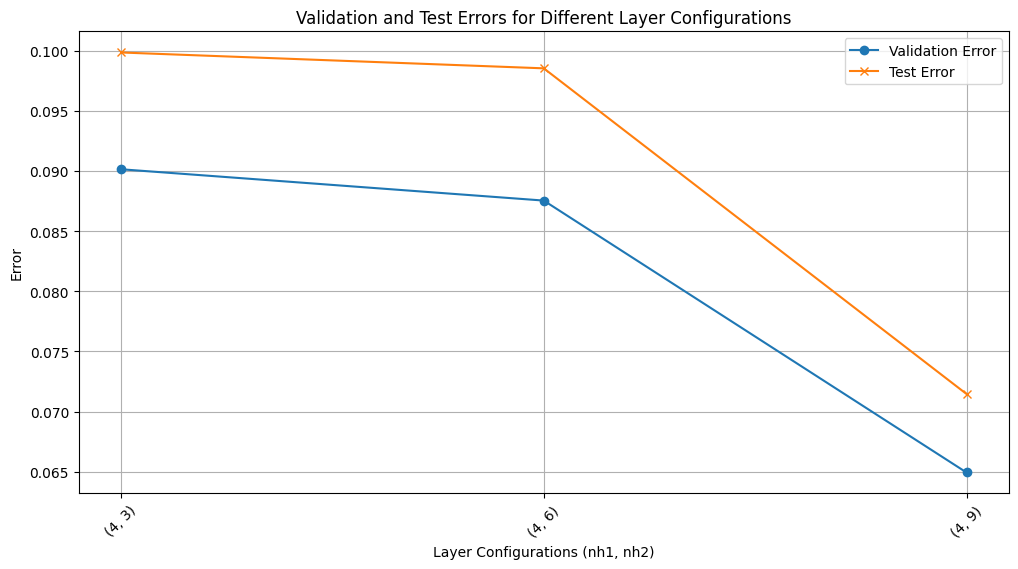

Test error for the best configuration: 0.38112980127334595
Test error for the worst configuration: 0.20316947996616364

Noise Level σ = 0.05, Weight Decay λ = 0.0:
  Best configuration: (4, 9)
  Worst configuration: (4, 3)

Noise Level σ = 0.05, Weight Decay λ = 0.01:
  Best configuration: (4, 9)
  Worst configuration: (4, 6)

Noise Level σ = 0.05, Weight Decay λ = 0.1:
  Best configuration: (4, 9)
  Worst configuration: (4, 3)

Noise Level σ = 0.09, Weight Decay λ = 0.0:
  Best configuration: (4, 6)
  Worst configuration: (4, 9)

Noise Level σ = 0.09, Weight Decay λ = 0.01:
  Best configuration: (4, 9)
  Worst configuration: (4, 3)

Noise Level σ = 0.09, Weight Decay λ = 0.1:
  Best configuration: (4, 9)
  Worst configuration: (4, 6)

Noise Level σ = 0.15, Weight Decay λ = 0.0:
  Best configuration: (4, 9)
  Worst configuration: (4, 3)

Noise Level σ = 0.15, Weight Decay λ = 0.01:
  Best configuration: (4, 9)
  Worst configuration: (4, 3)

Noise Level σ = 0.15, Weight Decay λ = 0.1:
 

In [5]:
# new layer configs
best_nh1 = best_config[0]
nh2_values = [3, 6, 9]  
layer_configurations = [(best_nh1, nh2) for nh2 in nh2_values]

# Configs for noise and weight
noise_levels = [0.05, 0.09, 0.15] 
weight_decay_values = [0.0, 0.01, 0.1] 
results = {}
models = {}

for noise_level in noise_levels:
    for weight_decay in weight_decay_values:
        print(f"\n### Evaluating with Gaussian noise (σ = {noise_level}) and weight decay (λ = {weight_decay}) ###")
        
        train_noisy, val_noisy, test_noisy = generate_data(x, noise_std_factor=noise_level)
        
        best_config_noisy, worst_config_noisy, best_model_noisy, worst_model_noisy = train_and_evaluate(
            train_noisy, 
            val_noisy, 
            test_noisy, 
            layer_configurations, 
            early_stopping=True,
            weight_decay=weight_decay
        )
        
        results[(noise_level, weight_decay)] = {
            "best_config": best_config_noisy,
            "worst_config": worst_config_noisy
        }
        
        models[(noise_level, weight_decay)] = {
            "best_model": best_model_noisy,
            "worst_model": worst_model_noisy
        }

for (noise_level, weight_decay), res in results.items():
    print(f"\nNoise Level σ = {noise_level}, Weight Decay λ = {weight_decay}:")
    print(f"  Best configuration: {res['best_config']}")
    print(f"  Worst configuration: {res['worst_config']}")
